# Q1:

#### Gaussian Processes (GPs) and Stochastic Processes

A stochastic process is a collection of random variables indexed by time or space, such as $\{X_t\}_{t \in T}$, where each $X_t$ is a random variable.

A Gaussian Process (GP) is a specific type of stochastic process where any finite set of function values \((f(x_1), \dots, f(x_n))\) follows a multivariate normal distribution:

  $
  f(x) \sim \mathcal{GP}(m(x), k(x, x'))
$

  where \(m(x)\) is the mean function and \(k(x, x')\) is the covariance (kernel) function that encodes relationships between inputs.



#### Variational Inference using the Evidence Lower Bound (ELBO)

Variational Inference (VI) is a method for approximating the true posterior $p(\theta \mid x)$ with a simpler distribution $q(\theta)$ by minimizing the KL divergence:

  $
  \mathrm{KL}(q(\theta) \parallel p(\theta \mid x)) = \log p(x) - \mathrm{ELBO}(q)
  $

 The Evidence Lower Bound (ELBO) is defined as:

  $
  \mathrm{ELBO}(q) = \mathbb{E}_{q(\theta)}[\log p(x, \theta)] - \mathbb{E}_{q(\theta)}[\log q(\theta)]
  $

  Maximizing the ELBO helps approximate the marginal likelihood while regularizing the complexity of $q(\theta)$.


/usr/local/lib/python3.11/dist-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


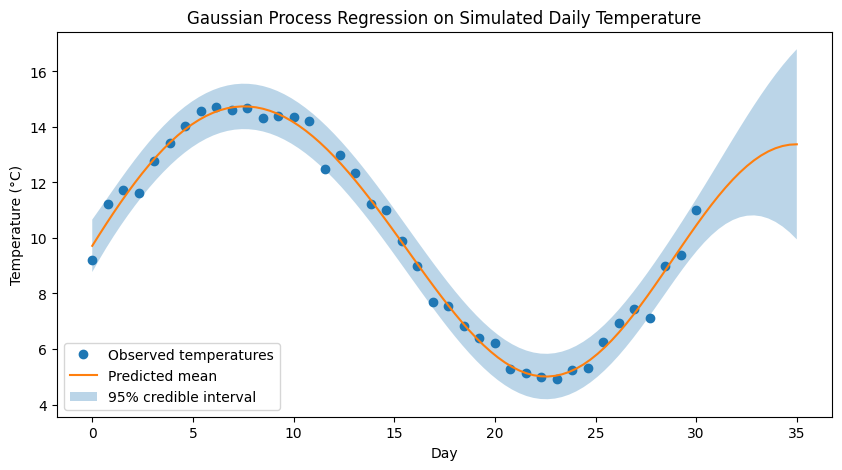

In [4]:
#Q2
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

# Create synthetic data (days vs temperature)
# Simulate a seasonal temperature curve with noise
days = np.linspace(0, 30, 40)[:, None]  # 40 time points over a month
temperature = 10 + 5 * np.sin(days.flatten() * np.pi / 15) + np.random.normal(0, 0.5, size=40)

# Build Gaussian Process model using Marginal likelihood
with pm.Model() as gp_temp_model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)                # GP lengthscale
    η = pm.HalfNormal("η", sigma=1.5)                 # GP amplitude
    cov = η**2 * pm.gp.cov.ExpQuad(1, ℓ)              # Squared exponential kernel

    gp = pm.gp.Marginal(cov_func=cov)                 # GP with marginal likelihood
    σ = pm.HalfNormal("σ", sigma=0.5)                 # Observation noise

    y_obs = gp.marginal_likelihood("temperature", X=days, y=temperature, noise=σ)

    trace = pm.sample(1000, chains=2, progressbar=False)  # Bayesian inference

# Use the trained GP to make predictions
future_days = np.linspace(0, 35, 100)[:, None]

# Extract posterior means for ℓ, η, σ
posterior_means = {var: trace.posterior[var].mean().item() for var in ["ℓ", "η", "σ"]}

with gp_temp_model:
    mean_pred, var_pred = gp.predict(future_days, point=posterior_means, diag=True, pred_noise=True)

std_pred = np.sqrt(var_pred)


# Visualize results
plt.figure(figsize=(10, 5))
plt.plot(days, temperature, "o", label="Observed temperatures")
plt.plot(future_days, mean_pred, label="Predicted mean")
plt.fill_between(future_days.ravel(),
                 mean_pred - 2 * std_pred,
                 mean_pred + 2 * std_pred,
                 alpha=0.3, label="95% credible interval")
plt.xlabel("Day")
plt.ylabel("Temperature (°C)")
plt.title("Gaussian Process Regression on Simulated Daily Temperature")
plt.legend()
plt.show()

In [5]:
#Q3
import pymc as pm
import numpy as np
import pytensor.tensor as pt
import matplotlib.pyplot as plt

# Create synthetic classification data for fraud detection
np.random.seed(123)

# Simulated features: transaction amount and time gap between transactions
X = np.random.normal(0, 1, size=(300, 2))
w_real = np.array([2.0, -1.2])
fraud_score = X @ w_real
y = np.random.binomial(n=1, p=1 / (1 + np.exp(-fraud_score)))  # 0 = legitimate, 1 = fraud

# Define a simple Bayesian Neural Net using VI
with pm.Model() as bnn_vi_model:
    # Layer 1 weights and biases
    W1 = pm.Normal("W1", mu=0, sigma=1, shape=(2, 4))
    b1 = pm.Normal("b1", mu=0, sigma=1, shape=(4,))

    # Layer 2 weights and biases
    W2 = pm.Normal("W2", mu=0, sigma=1, shape=(4,))
    b2 = pm.Normal("b2", mu=0, sigma=1)

    # Forward pass through network
    hidden_layer = pm.math.tanh(pt.dot(X, W1) + b1)
    output_logits = pm.math.dot(hidden_layer, W2) + b2

    # Output likelihood
    y_obs = pm.Bernoulli("y_obs", logit_p=output_logits, observed=y)

    # Variational inference with ADVI and ELBO optimization
    approx = pm.fit(10000, method="advi", obj_optimizer=pm.adagrad(learning_rate=0.01))
    trace_vi = approx.sample(1000)


Output()